#  Прогнозирование цены на автомобиль

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [63]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# модель
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# метрика
from sklearn.metrics import mean_squared_error

In [64]:
# чтение файла и печать общей информации
df_autos = pd.read_csv('/datasets/autos.csv')

df_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Датасет представлен в виде следующиих данных.

**Признаки:**
    
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

In [65]:
# поменяем формат даты.
df_autos['DateCrawled'] = pd.to_datetime(df_autos['DateCrawled'], format='%Y-%m-%d %H:%M')
df_autos['DateCreated'] = pd.to_datetime(df_autos['DateCreated'], format='%Y-%m-%d %H:%M')
df_autos['LastSeen'] = pd.to_datetime(df_autos['LastSeen'], format='%Y-%m-%d %H:%M')
df_autos = df_autos.drop(['DateCrawled', 'DateCreated' , 'LastSeen'], axis=1)

In [66]:
df_autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


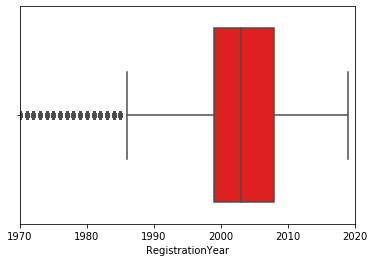

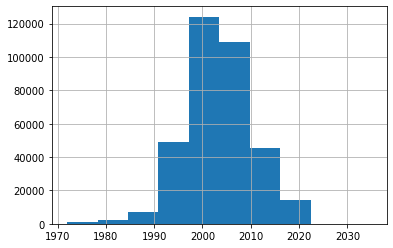

In [67]:
def boxplot_print(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    sns.boxplot(x=colum, color='red')   
    plt.show()
    colum.hist(bins=bins, range=((q1-3*iqr), (q3+3*iqr)))
    plt.show()
    
plt.xlim(1970, 2020)
boxplot_print(df_autos['RegistrationYear'], 10)

count    350812.000000
mean       2003.423021
std           6.611317
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64


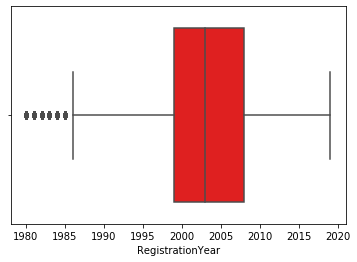

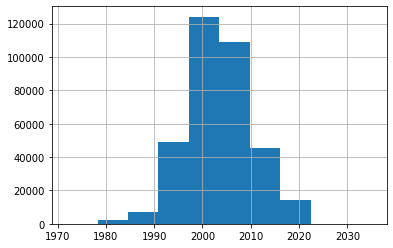

CPU times: user 619 ms, sys: 16.3 ms, total: 635 ms
Wall time: 649 ms


In [68]:
%%time

#df_autos = df_autos.loc[df_autos.loc[:,'RegistrationYear'] >= 1980]
#df_autos = df_autos.loc[df_autos.loc[:,'RegistrationYear'] <= 2020]

df_autos_filtr = df_autos.query("1980 <= RegistrationYear <= 2020")
boxplot_print(df_autos_filtr['RegistrationYear'], 10)

count    350812.000000
mean        110.418603
std         188.270170
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


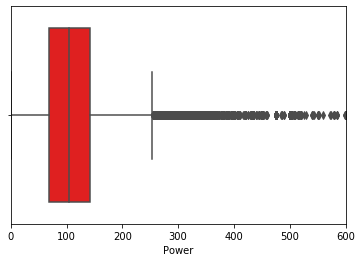

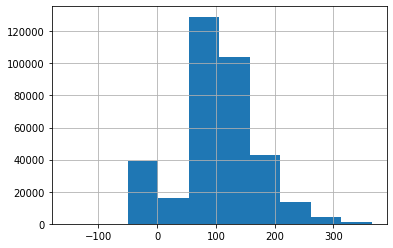

In [69]:
#
plt.xlim(0, 600)
boxplot_print(df_autos_filtr['Power'], 10)


count    303111.000000
mean        122.677042
std          52.448562
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         500.000000
Name: Power, dtype: float64


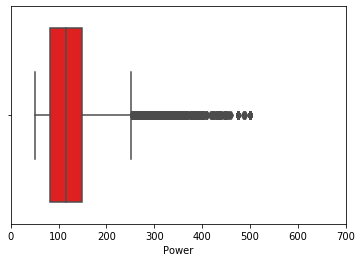

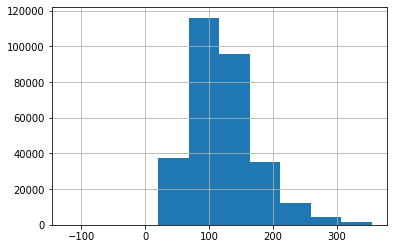

In [70]:
#

df_autos_filtr = df_autos.query("50 < Power <= 500")
#df_autos_filtr = df_autos_filtr.loc[df_autos_filtr.loc[:,'Power'] <= 250]
#df_autos_filtr = df_autos_filtr.loc[df_autos_filtr.loc[:,'Power'] > 10]

plt.xlim(0, 700)
boxplot_print(df_autos_filtr['Power'], 10)

count    303111.000000
mean       4812.010442
std        4609.008359
min           0.000000
25%        1300.000000
50%        3150.000000
75%        6990.000000
max       20000.000000
Name: Price, dtype: float64


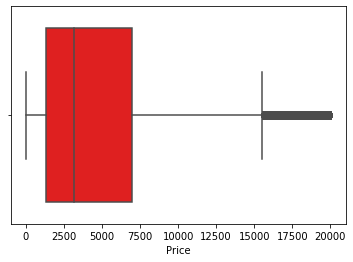

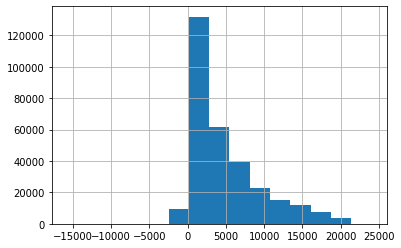

(0, 20000)

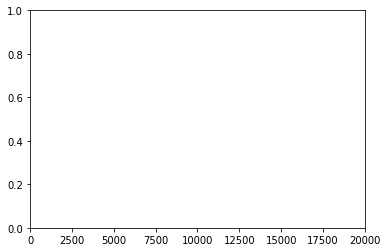

In [71]:
#
boxplot_print(df_autos_filtr['Price'], 15)
plt.xlim(0, 20000)

count    295033.000000
mean       4943.508767
std        4601.709285
min         101.000000
25%        1450.000000
50%        3300.000000
75%        7000.000000
max       20000.000000
Name: Price, dtype: float64


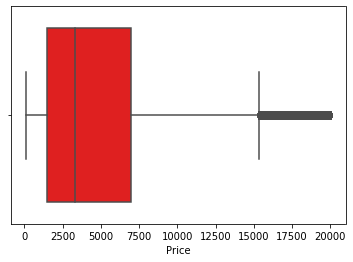

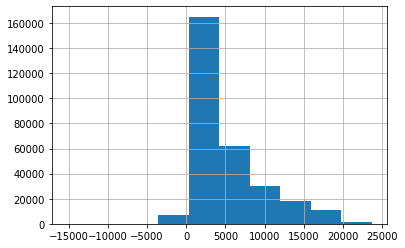

(0, 20000)

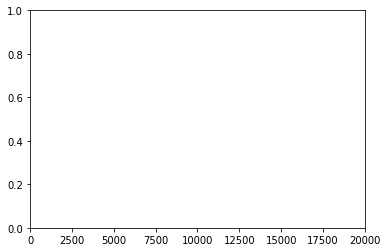

In [72]:
df_autos_filtr = df_autos_filtr.loc[df_autos_filtr.loc[:,'Price'] > 100]
df_autos_filtr = df_autos_filtr.loc[df_autos_filtr.loc[:,'Price'] <= 20000]

boxplot_print(df_autos_filtr['Price'], 10)
plt.xlim(0, 20000)

In [73]:
#
df_autos_filtr.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,295033.000000,295033.000000,295033.000000,295033.000000,295033.000000,295033.0,295033.000000
mean,4943.508767,2003.728095,122.830999,128568.126277,5.987710,0.0,51302.062315
std,4601.709285,29.956020,52.391091,36529.338308,3.588769,0.0,25760.342829
min,101.000000,1000.000000,51.000000,5000.000000,0.000000,0.0,1067.000000
25%,1450.000000,1999.000000,82.000000,125000.000000,3.000000,0.0,30989.000000
50%,3300.000000,2004.000000,115.000000,150000.000000,6.000000,0.0,50321.000000
75%,7000.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72116.000000
max,20000.000000,9999.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


In [74]:
# суммарное количество пропусков
df_autos_filtr.isnull().sum()

Price                    0
VehicleType          19962
RegistrationYear         0
Gearbox               5354
Power                    0
Model                11429
Kilometer                0
RegistrationMonth        0
FuelType             18209
Brand                    0
NotRepaired          43938
NumberOfPictures         0
PostalCode               0
dtype: int64

NotRepaired — была машина в ремонте или нет. Вероятней всего если пропущено значение, то машина не была в ремонте. По этой логике заменим пропуски на "no"

Из огромного модельного ряда подобрать модель сложно, и чтобы дальнейшая обработка была пропусков былва точнее удалим пропущенные значения в столбце 'Model'.

In [75]:
# замена пропусков в столбце NotRepaired
df_autos_filtr['NotRepaired'] = df_autos_filtr['NotRepaired'].fillna('unknown')

# удаление пропусков в столбце Model
df_autos_filtr.dropna(subset=['Model'], inplace = True)

df_autos_filtr['NotRepaired'].unique()

array(['unknown', 'no', 'yes'], dtype=object)

In [76]:
df_autos_filtr.groupby(['Brand', 'Model'])['Gearbox'].value_counts()

Brand       Model     Gearbox
alfa_romeo  145       manual      35
            147       manual     492
                      auto        22
            156       manual     496
                      auto        40
                                ... 
volvo       v60       auto        14
            v70       manual     361
                      auto       213
            xc_reihe  auto       191
                      manual      66
Name: Gearbox, Length: 566, dtype: int64

Остальные пропуски заменим наиболее частыми значения. Для этого сгруппируем даные по бренду и модели.

In [77]:
# заполнение пропусков по столбщаем 
df_autos_filtr["VehicleType"] = (df_autos_filtr
                                 .groupby(['Brand', 'Model'])['VehicleType']
                                 .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
                                )
df_autos_filtr["Gearbox"] = (df_autos_filtr
                                 .groupby(['Brand', 'Model'])['Gearbox']
                                 .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
                                )
df_autos_filtr["FuelType"] = (df_autos_filtr
                                 .groupby(['Brand', 'Model'])['FuelType']
                                 .transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
                                )

# суммарное количество пропусков
df_autos_filtr.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
PostalCode           0
dtype: int64

In [78]:
# количества дубликатов в таблице
df_autos_filtr.duplicated().sum()

18906

In [79]:
# удаление всех дубликатов из таблицы df 
df_autos_filtr = df_autos_filtr.drop_duplicates().reset_index(drop=True)

df_autos_filtr = df_autos_filtr.drop(['NumberOfPictures', 'PostalCode'], axis=1)

In [80]:
# кодирование данных
data_ohe = pd.get_dummies(df_autos_filtr, drop_first=True)
data_ohe.head(2)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [81]:
# разделение на 2 выборки (обучающая и валидационная)
df_train, df_valid = train_test_split(data_ohe, test_size=0.2, random_state=12345)
# размер таблицы
print(data_ohe.shape)
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])

# добавил 3ю выборку для теста, того же размера, что и валидационная
df_test_size = df_valid.shape[0] / df_train.shape[0]
df_train, df_test = train_test_split(df_train, test_size=df_test_size, random_state=12345)
print()
print('Кол-во строк в обучающей выборке:', df_train.shape[0])
print('Кол-во строк в валидационной выборке:', df_valid.shape[0])
print('Кол-во строк в тестовой выборке:', df_test.shape[0])


numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

# разделение на обучающие признаки и целевые
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


(264698, 306)
Кол-во строк в обучающей выборке: 211758
Кол-во строк в валидационной выборке: 52940

Кол-во строк в обучающей выборке: 158818
Кол-во строк в валидационной выборке: 52940
Кол-во строк в тестовой выборке: 52940


In [82]:
df_before = df_autos.shape[0]
df_after = data_ohe.shape[0]

print('Изначальный размер:',df_before)
print('Размер после предобработки:', df_after)
print('Разница в колличесве строк', df_before - df_after)
print(((df_before - df_after) / df_before) * 100,'%')

Изначальный размер: 354369
Размер после предобработки: 264698
Разница в колличесве строк 89671
25.30441432518081 %


# 2. Обучение моделей

In [83]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

# словарь для результатов тесторвания
test_score = {}

## 2.1.  LinearRegression

In [84]:
%%time
# mean_squared_error(y_true, y_pred, squared=False)
# обучим модель и проведем крос валидацию
line_reg_model = LinearRegression().fit(features_train, target_train)
predictions = line_reg_model.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
rmse_train

predictions_valid = line_reg_model.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5
    
predictions_test = line_reg_model.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_valid ** 0.5


CPU times: user 14.1 s, sys: 5.15 s, total: 19.3 s
Wall time: 19.3 s


In [85]:
test_score['LinearRegression'] = [rmse_train, rmse_valid, rmse_test, '17.8 s']

## 2.2.  DecisionTreeRegressor

In [86]:
%%time
for depth in np.arange(10, 20):
    regr = (DecisionTreeRegressor(max_depth=depth, random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("max_depth =", depth, ":")
    print("Результат проверки на обучающей  выборке", rmse)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

max_depth = 10 :
Результат проверки на обучающей  выборке 1878.5910034597734
Результат проверки на валидационной выборке 2010.712288275109

max_depth = 11 :
Результат проверки на обучающей  выборке 1789.0020448951736
Результат проверки на валидационной выборке 1968.358585624999

max_depth = 12 :
Результат проверки на обучающей  выборке 1700.4027508929607
Результат проверки на валидационной выборке 1926.314271059399

max_depth = 13 :
Результат проверки на обучающей  выборке 1611.8927892367763
Результат проверки на валидационной выборке 1909.3862557184661

max_depth = 14 :
Результат проверки на обучающей  выборке 1525.8586107903193
Результат проверки на валидационной выборке 1900.3901531128408

max_depth = 15 :
Результат проверки на обучающей  выборке 1440.2069921255938
Результат проверки на валидационной выборке 1911.3209025250019

max_depth = 16 :
Результат проверки на обучающей  выборке 1359.5992446182588
Результат проверки на валидационной выборке 1919.2716861306255

max_depth = 17 :

In [87]:
%%time
regr = (DecisionTreeRegressor(max_depth=14, random_state=12345)
        .fit(features_train, target_train)
       )
predictions_test = regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 4.35 s, sys: 205 ms, total: 4.56 s
Wall time: 4.68 s


1890.1481606515317

In [88]:
test_score['DecisionTreeRegressor'] = [rmse_train, rmse_valid, rmse_test, '4.46 s']

При увеличение числа деревьев, модель сильно переобучивается и  качество предсказаний падает.

## 2.3.  RandomForestRegressor

In [89]:
%%time
for estim in np.arange(37, 45):
    rf_regr = (RandomForestRegressor(max_depth=14, 
                                     n_estimators=estim,
                                     random_state=12345)
        .fit(features_train, target_train)
       )
    predictions = rf_regr.predict(features_train)
    mse = mean_squared_error(target_train, predictions)
    rmse = mse ** 0.5
    
    predictions_valid = rf_regr.predict(features_valid)
    mse_valid = mean_squared_error(target_valid, predictions_valid)
    rmse_valid = mse_valid ** 0.5
    
    print("n_estimators =", estim, ":")
    print("Результат проверки на обучающей  выборке", rmse)
    print("Результат проверки на валидационной выборке", rmse_valid)
    print()

n_estimators = 37 :
Результат проверки на обучающей  выборке 1440.0451372763841
Результат проверки на валидационной выборке 1721.6456493530127

n_estimators = 38 :
Результат проверки на обучающей  выборке 1439.9254508307963
Результат проверки на валидационной выборке 1721.5118991839404

n_estimators = 39 :
Результат проверки на обучающей  выборке 1439.8144363515971
Результат проверки на валидационной выборке 1721.7571401477217

n_estimators = 40 :
Результат проверки на обучающей  выборке 1439.6668574587375
Результат проверки на валидационной выборке 1721.4683946116781

n_estimators = 41 :
Результат проверки на обучающей  выборке 1439.5182702191291
Результат проверки на валидационной выборке 1721.351394788075

n_estimators = 42 :
Результат проверки на обучающей  выборке 1439.5400141515129
Результат проверки на валидационной выборке 1721.6332585719094

n_estimators = 43 :
Результат проверки на обучающей  выборке 1439.4092853004593
Результат проверки на валидационной выборке 1721.14124369

In [90]:
%%time
rf_regr = (RandomForestRegressor(max_depth=14,
                                 n_estimators=42,
                                 random_state=12345
                                )
           .fit(features_train, target_train)
          )
predictions = rf_regr.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = rf_regr.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = rf_regr.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 2min, sys: 379 ms, total: 2min 1s
Wall time: 2min 2s


1706.2479709781828

In [91]:
test_score['RandomForestRegressor']  = [rmse_train, rmse_valid, rmse_test, '1min 57s']

In [92]:
%%time
# авоматизизированный перебор параметрров для проверки результата с помощью GridSearchCV
###parameters = {'max_depth': range(15, 100, 2)}
#gs = GridSearchCV(DecisionTreeRegressor(random_state=12345), 
#                  parameters,
#                  cv=kf,
#                  scoring='neg_mean_squared_error')

# обучение
#gs.fit(features_train, target_train)
# просмотр лучших параметров
#gs.best_params_


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


## 2.4.  LGBMRegressor

In [107]:
%%time
parameters = {'max_depth': np.arange(13, 15),
              'n_estimators': np.arange(37, 45)
             }

gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                  parameters,
                  cv=kf,
                  scoring='neg_mean_squared_error')

# обучение
gs.fit(features_train, target_train)
# просмотр лучших параметров
gs.best_params_


CPU times: user 7min 33s, sys: 20.9 s, total: 7min 54s
Wall time: 7min 59s


{'max_depth': 13, 'n_estimators': 44}

In [108]:
# лучший результат
gs.best_score_

-3142401.5883854367

In [104]:
%%time
model_lgb = (LGBMRegressor(max_depth=14, 
                           n_estimators=39,
                           random_state=12345)
             .fit(features_train, target_train)
            )

predictions = model_lgb.predict(features_train)
mse = mean_squared_error(target_train, predictions)
rmse_train = mse ** 0.5
    
predictions_valid = model_lgb.predict(features_valid)
mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = mse_valid ** 0.5

predictions_test = model_lgb.predict(features_test)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 6.67 s, sys: 582 ms, total: 7.25 s
Wall time: 7.26 s


1790.4993568922073

In [105]:
test_score['LGBMRegressor'] = [rmse_train, rmse_valid, rmse_test, '9.34 s']

# 3. Анализ моделей

In [106]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['RMSE train', 'RMSE valid', 'RMSE test', 'Speed'], orient='index')
df_score

,RMSE train,RMSE valid,RMSE test,Speed
LinearRegression,2782.596840,2801.311675,2801.311675,17.8 s
DecisionTreeRegressor,2782.596840,1958.419797,1890.148161,4.46 s
RandomForestRegressor,1439.540014,1721.633259,1706.247971,1min 57s
LGBMRegressor,1787.436646,1819.773445,1790.499357,9.34 s


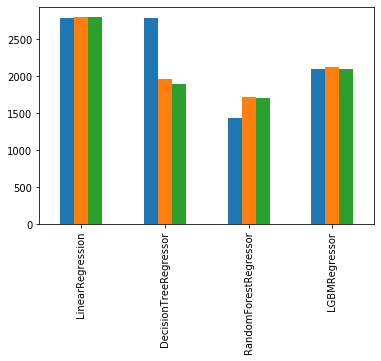

In [103]:
df_score.plot(kind='bar', legend=False)

### Выводы:

Можель LGBMRegressor показывается наилучший результат как по качеству так и по времени.
RandomForestRegressor показывает чуть лучший результат по качеству но время обучения в разы дольше.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [X]  Есть анализ скорости работы и качества моделей